In [75]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In this notebook, we will use TensorFlow to build a model which can classify images of hand-drawn numbers (from 0 to 9). In particular, we will create a standard neural network with dropout and ultilizing mini-batches. 

We will train/test using the MNIST dataset. I assume basic familiarity with MNIST and also with commonly-used deep learning terminology.

# The Model + Optimization

We begin by loading in the dataset. 

In [76]:
MNIST = input_data.read_data_sets('data/', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


Now, let's decide the topology of our network using a list called 'layer_dims'. This list will contain the number of neurons in each layer. We will work with layer_dims when creating our model, so I believe that defining it early is useful for learning purposes.

We will have 28x28 input features, 500 neurons in the first layer, 250 in the second, 125 in the third, and we have 10 output classes. 

In [77]:
layer_dims = [784, 500, 250, 125, 10]

Next, let's create our placeholders, which will be filled with values once we run our tensorflow session. 

In [78]:
x = tf.placeholder('float', [None, layer_dims[0]]) #input
y = tf.placeholder('float', [None, layer_dims[-1]]) #output
probability = tf.placeholder('float') #dropout probability of keeping

We need a function 'initialize()' to initialize the weights and biases given our network topology. 

In [79]:
def initialize(layer_dims):
    
    parameters = {}
    
    for l in range(1, len(layer_dims)):
        parameters['W' + str(l)] = tf.Variable(tf.random_normal([layer_dims[l-1], layer_dims[l]], stddev = 0.1))
        parameters['b' + str(l)] = tf.Variable(tf.random_normal([layer_dims[l]]))
        
    return parameters

We also need a function 'forward()' to complete the forward propagation.

In [80]:
def forward(x, parameters, probability, layer_dims):

    layers = {}
    
    for l in range(1, len(layer_dims) - 1):
        x = tf.nn.relu(tf.add(tf.matmul(x, parameters['W' + str(l)]), parameters['b' + str(l)]))
        layers['layer' + str(l)] = x
        
    x = tf.nn.relu(tf.add(tf.matmul(layers['layer' + str(len(layer_dims) - 3)], parameters['W' + str(len(layer_dims) - 2)]),\
        parameters['b' + str(len(layer_dims) - 2)]))
    layers['layer' + str(len(layer_dims) - 2)] = tf.nn.dropout(x, probability) 
    
    return (tf.matmul(layers['layer' + str(len(layer_dims) - 2)], parameters['W' + str(len(layer_dims) - 1)])\
            + parameters['b' + str(len(layer_dims) - 1)])

Now, let's prepare to optimize the model.

In [87]:
parameters = initialize(layer_dims)
predictions = forward(x, parameters, probability, layer_dims)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = predictions, labels = y)) 
opt = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost) 
result = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))    
accuracy = tf.reduce_mean(tf.cast(result, "float"))

Finally, we optimize using mini-batches of 100 and 15 epochs.

In [82]:
start = tf.initialize_all_variables()
sess = tf.Session()
sess.run(start)

for epoch in range(15):
    
    batches = int(MNIST.train.num_examples/100)
    average = 0.0
    
    for i in range(batches):
        x_, y_ = MNIST.train.next_batch(100)
        sess.run(opt, feed_dict = {x: x_, y: y_, probability: 0.5})
        average = average + sess.run(cost, feed_dict = {x: x_, y: y_, probability: 1.0})
        
    average = average/batches

    print('epoch number: ' + str(epoch + 1))
    print('cost: ' + str(average))
    train_accuracy = sess.run(accuracy, feed_dict = {x: x_, y: y_, probability: 1.0})
    print('training accuracy: ' + str(train_accuracy))
    test_accuracy = sess.run(accuracy, feed_dict = {x: MNIST.test.images, y: MNIST.test.labels, probability: 1.0})
    print('testing accuracy: ' + str(test_accuracy))

epoch number: 1
cost: 0.2843735211850567
training accuracy: 0.96
testing accuracy: 0.9548
epoch number: 2
cost: 0.09861007609997283
training accuracy: 0.98
testing accuracy: 0.9678
epoch number: 3
cost: 0.060979520800438794
training accuracy: 0.98
testing accuracy: 0.9702
epoch number: 4
cost: 0.041437779547731306
training accuracy: 0.99
testing accuracy: 0.9726
epoch number: 5
cost: 0.029306886420288884
training accuracy: 0.98
testing accuracy: 0.9752
epoch number: 6
cost: 0.021961649753449653
training accuracy: 1.0
testing accuracy: 0.9781
epoch number: 7
cost: 0.0164081841009796
training accuracy: 1.0
testing accuracy: 0.9801
epoch number: 8
cost: 0.011004307649246502
training accuracy: 1.0
testing accuracy: 0.9807
epoch number: 9
cost: 0.010923360799682666
training accuracy: 1.0
testing accuracy: 0.9786
epoch number: 10
cost: 0.00970885508689786
training accuracy: 1.0
testing accuracy: 0.9805
epoch number: 11
cost: 0.00692673334892871
training accuracy: 1.0
testing accuracy: 0.9814

The model is 97.96% accurate for the training set, which is decent for a standard (e.g. non-convolutional) neural network. 

# Predicting a Single Image

Now that we have an optimized model, let's test it on a custom image. I've drawn a "3" and saved it as a jpeg titled '0test3.jpg'. Note that this image follows the same format of the MNIST dataset (28x28, greyscale, white text on a black background). Also note that the image must be normalized and reshaped before we predict. 

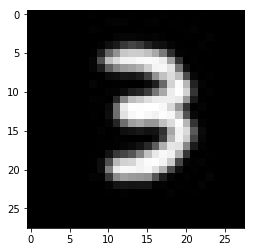

In [83]:
img = mpimg.imread('0test3.jpg')
plt.imshow(img, cmap = 'gray')
img = img/255 #normalization
img = np.reshape(img, (1, 784))

We feed the model the image, softmax the output, and then take the argmax to get a final prediction.

In [84]:
img_predict = sess.run(predictions, feed_dict = {x: img, probability: 1})
img_predict = tf.nn.softmax(img_predict, axis = -1)
arg_max = tf.argmax(input=img_predict, axis=1)
print(sess.run(arg_max))

[3]


The model predicted a '3', which is correct.

As a quick aside, let's see what happens when the input image doesn't follow the format of the MNIST dataset. In particular, what happens if we predict the same image but with inverted colors, so that the text is black and the background is white?

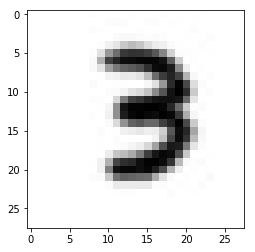

In [85]:
img2 = mpimg.imread('0test2.jpg')
plt.imshow(img2, cmap = 'gray')
img2 = img2/255
img2 = np.reshape(img2, (1, 784))

In [86]:
img_predict2 = sess.run(predictions, feed_dict = {x: img2, probability: 1})
img_predict2 = tf.nn.softmax(img_predict2, axis = -1)
arg_max = tf.argmax(input=img_predict2, axis=1)
print(sess.run(arg_max))

[0]


We see that the model incorrectly predicted '0' for the inverted image. 

If we want correct predictions for images which consist of black text on a white background, we must train the model with images following this format. One simple way to do this would be to invert every image in the MNIST dataset (keeping the corresponding labels the same) and then retrain the model. This would be an example of data augmentation. 